# Test plane-based registration
Test different plane-based registration methods

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import torch

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import get_correspondences, extract_corresponding_features
from planeslam.geometry.util import quat_to_rot_mat

%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(suppress=True)

### Load AirSim data

In [3]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

In [4]:
# Extract scans
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

### Decoupled

In [17]:
from planeslam.registration import decoupled_register

abs_traj_transformations = np.zeros((num_scans-1,4,4))
T_abs = np.eye(4)
avg_runtime = 0

for i in range(len(scans)-1):
    start_time = time.time()
    R_hat, t_hat = decoupled_register(scans[i+1], scans[i])
    avg_runtime += time.time() - start_time
    print(t_hat)
    T_hat = np.vstack((np.hstack((R_hat, t_hat)), np.hstack((np.zeros(3), 1))))
    T_abs = T_hat @ T_abs
    abs_traj_transformations[i,:,:] = T_abs

avg_runtime /= len(scans)-1
print("average registration time: ", avg_runtime)

[[ 0.14497635]
 [-1.19585232]
 [ 1.23233305]]
[[-0.009191  ]
 [-2.52738824]
 [-1.79024574]]
[[-0.04968349]
 [-3.96158334]
 [-0.35020581]]
[[ 0.07913207]
 [-4.28462333]
 [-0.36805397]]
[[-0.00431424]
 [-4.27786121]
 [-0.08658879]]
[[-0.26258462]
 [-3.90487242]
 [-0.13504622]]
[[ 0.22214625]
 [-4.42489485]
 [-0.05538656]]
[[-0.00723413]
 [-4.88605856]
 [-0.06641226]]
[[ 0.01852842]
 [-3.84844831]
 [-0.00602313]]
[[-0.05195909]
 [-4.39408373]
 [-0.10790757]]
[[ 0.07059074]
 [-4.49969582]
 [ 0.02493389]]
[[ 0.03843188]
 [-4.32395508]
 [-0.03132654]]
[[-0.00581487]
 [-4.32327865]
 [-0.058571  ]]
[[-0.01511899]
 [-4.42720059]
 [-0.04802296]]
[[0.]
 [0.]
 [0.]]
[[-2.55330505]
 [-2.30044185]
 [-0.73840521]]
[[-3.6066075 ]
 [ 0.31113987]
 [-0.05197913]]
[[-3.98551429]
 [ 1.22987338]
 [-0.17659265]]
[[-4.22028267]
 [ 0.9363781 ]
 [-0.23909822]]
[[-4.3139801 ]
 [-1.97337272]
 [-0.3618971 ]]
[[-4.65234311]
 [ 1.43354145]
 [-0.1009428 ]]
[[-4.4184418 ]
 [-0.23338686]
 [-0.03953195]]
[[-4.4472641 ]


In [18]:
np.round(abs_traj_transformations[:,:3,3],2)

array([[   0.14,   -1.2 ,    1.23],
       [   0.14,   -3.5 ,   -0.38],
       [   0.09,   -7.48,   -0.48],
       [   0.17,  -11.77,   -0.73],
       [   0.15,  -16.06,   -0.75],
       [  -0.19,  -19.96,   -0.84],
       [   0.09,  -24.39,   -0.9 ],
       [   0.07,  -29.27,   -0.97],
       [   0.15,  -33.12,   -0.97],
       [   0.13,  -37.52,   -1.1 ],
       [   0.11,  -42.02,   -0.75],
       [   0.05,  -46.34,   -1.1 ],
       [  -0.1 ,  -50.66,   -1.19],
       [   0.07,  -55.09,   -1.28],
       [   0.07,  -55.09,   -1.28],
       [  -6.9 ,  -57.2 ,   -2.65],
       [ -11.53,  -55.04,  -14.19],
       [ -15.52,  -50.75,  -23.17],
       [ -20.  ,  -49.15,  -24.64],
       [ -24.6 ,  -52.57,  -21.62],
       [ -29.04,  -52.41,  -18.6 ],
       [ -33.53,  -52.83,  -18.  ],
       [ -38.  ,  -52.54,  -18.95],
       [ -42.54,  -52.01,  -19.99],
       [ -47.03,  -51.8 ,  -20.24],
       [ -51.42,  -52.01,  -19.99],
       [  -1.31,  -33.64,   67.58],
       [  -8.53,  -44.05,   

### Gauss-newton

In [19]:
from planeslam.registration import GN_register

abs_traj_transformations = np.zeros((num_scans-1,4,4))
T_abs = np.eye(4)
avg_runtime = 0

for i in range(len(scans)-1):
    start_time = time.time()
    R_hat, t_hat = GN_register(scans[i+1], scans[i])
    avg_runtime += time.time() - start_time
    print(t_hat)
    T_hat = np.vstack((np.hstack((R_hat, t_hat)), np.hstack((np.zeros(3), 1))))
    T_abs = T_hat @ T_abs
    abs_traj_transformations[i,:,:] = T_abs

avg_runtime /= len(scans)-1
print("average registration time: ", avg_runtime)

final loss:  83.94139681886668
[[-1.77978397]
 [ 3.78587628]
 [ 1.13993601]]
final loss:  296.08740057370056
[[-5.99483767]
 [-0.99286459]
 [-0.62273275]]
final loss:  532.6060383238397
[[-1.99583813]
 [ 7.00108123]
 [-8.3822632 ]]
final loss:  354.0010061519799
[[-1.94067019]
 [-7.37659953]
 [-3.45620138]]
final loss:  538.2522741659651
[[ 1.35798891]
 [-2.30654432]
 [-7.62343634]]
final loss:  1037.4145870989812
[[-1.76293648]
 [13.53722848]
 [-7.29668454]]
final loss:  1144.2592388623743
[[-7.22675596]
 [-3.18718976]
 [12.56364593]]
final loss:  731.8009446799133
[[-3.62711486]
 [-4.95079261]
 [ 9.08516534]]
final loss:  118.50585679199142
[[ 1.72213309]
 [-0.76670506]
 [ 3.86401278]]
final loss:  48.00569524683933
[[ 0.63156699]
 [ 4.0360315 ]
 [-0.27497872]]
final loss:  104.58491778998065
[[3.46421563]
 [5.55615645]
 [0.72919973]]
final loss:  349.1179725399021
[[ 4.65163556]
 [ 1.56955063]
 [-7.80628289]]
final loss:  75.30373642627441
[[ 5.27973919]
 [ 0.60496916]
 [-0.22839453

### Torch GN

In [6]:
# Set torch device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [18]:
from planeslam.registration import torch_GN_register

abs_traj_transformations = np.zeros((num_scans-1,4,4))
T_abs = np.eye(4)
avg_runtime = 0

for i in range(len(scans)-1):
    start_time = time.time()
    R_hat, t_hat = torch_GN_register(scans[i+1], scans[i], device)
    avg_runtime += time.time() - start_time
    T_hat = np.vstack((np.hstack((R_hat, t_hat)), np.hstack((np.zeros(3), 1))))
    T_abs = T_hat @ T_abs
    abs_traj_transformations[i,:,:] = T_abs

avg_runtime /= len(scans)-1
print("average registration time: ", avg_runtime)

final loss:  tensor(0.0561, device='cuda:0')
final loss:  tensor(2.2873e-05, device='cuda:0')
final loss:  tensor(0.0011, device='cuda:0')
final loss:  tensor(0.0125, device='cuda:0')
final loss:  tensor(4.6057e-05, device='cuda:0')
final loss:  tensor(0.3225, device='cuda:0')
final loss:  tensor(0.5791, device='cuda:0')
final loss:  tensor(0.0002, device='cuda:0')
final loss:  tensor(0.0008, device='cuda:0')
final loss:  tensor(0.1880, device='cuda:0')
final loss:  tensor(0.0335, device='cuda:0')
final loss:  tensor(1.8650e-05, device='cuda:0')
final loss:  tensor(8.8247e-06, device='cuda:0')
final loss:  tensor(8.8135e-05, device='cuda:0')
final loss:  tensor(0.0540, device='cuda:0')
final loss:  tensor(0.0481, device='cuda:0')
final loss:  tensor(0.0041, device='cuda:0')
final loss:  tensor(0.0011, device='cuda:0')
final loss:  tensor(0.0401, device='cuda:0')
average registration time:  0.16547326037758275


In [19]:
abs_traj_transformations[:,:3,3]

array([[  0.85242969,  -0.17511433,   0.46099803],
       [  3.86578401,  -0.18448835,  -0.81793949],
       [  7.93727657,  -0.16054584,  -1.57675279],
       [ 11.88235359,  -0.16209129,  -1.83140069],
       [ -1.31233959,  -0.20320465,  -1.60106996],
       [-54.7082944 ,  -0.33331479,  -0.4567437 ],
       [-50.21595889,  -0.18851305,  -0.47795158],
       [-45.34936841,  -0.29489144,  -0.85431675],
       [-40.96685859,  -0.29035487,  -0.88903056],
       [-36.68848303,  -0.31918539,  -0.88524444],
       [-32.16225538,  -0.25753459,   1.23664307],
       [-10.99923734,  -0.38604761,  31.57473473],
       [-11.66287586,  -0.49603589,  17.33897214],
       [ 23.38198133,  -0.40115413, -31.15007335],
       [ 20.19008722,  -0.24719924, -33.05992345],
       [ 15.48551456,  -0.198162  , -36.31558857],
       [ 14.47794143,  -0.15886574, -36.9004909 ],
       [ 16.36701664,  -0.21729733, -36.14826509],
       [ 17.08120406,  -0.15152083, -35.64666858]])

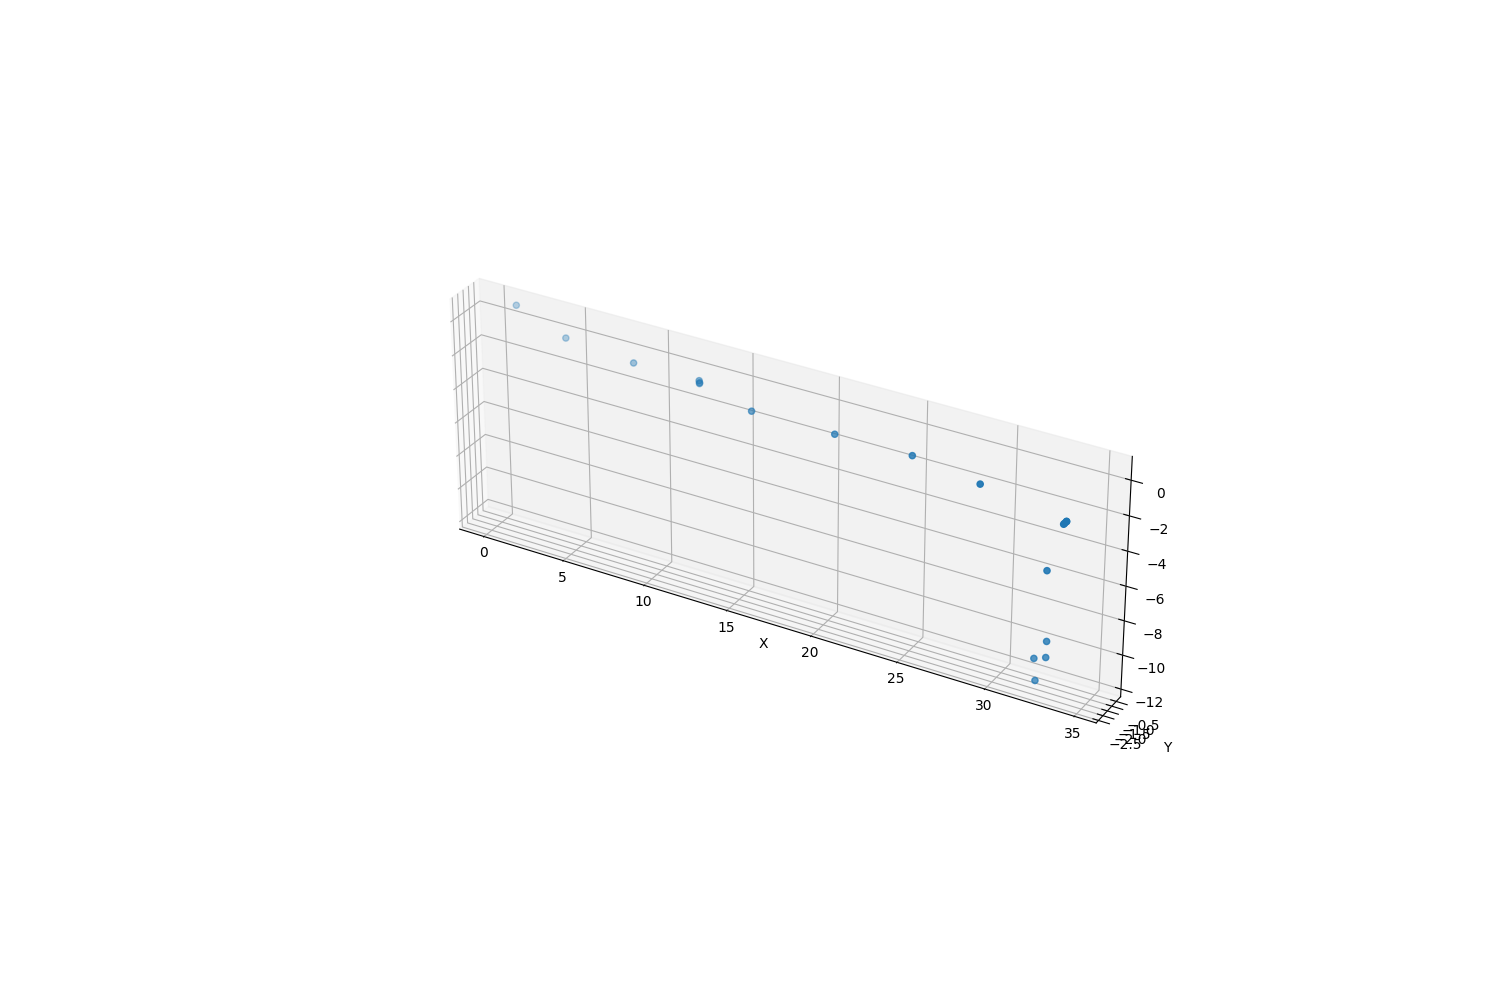

In [23]:
traj = abs_traj_transformations[:,:3,3]
ax = plot_3D_setup(traj)
ax.scatter(traj[:,0], traj[:,1], traj[:,2])

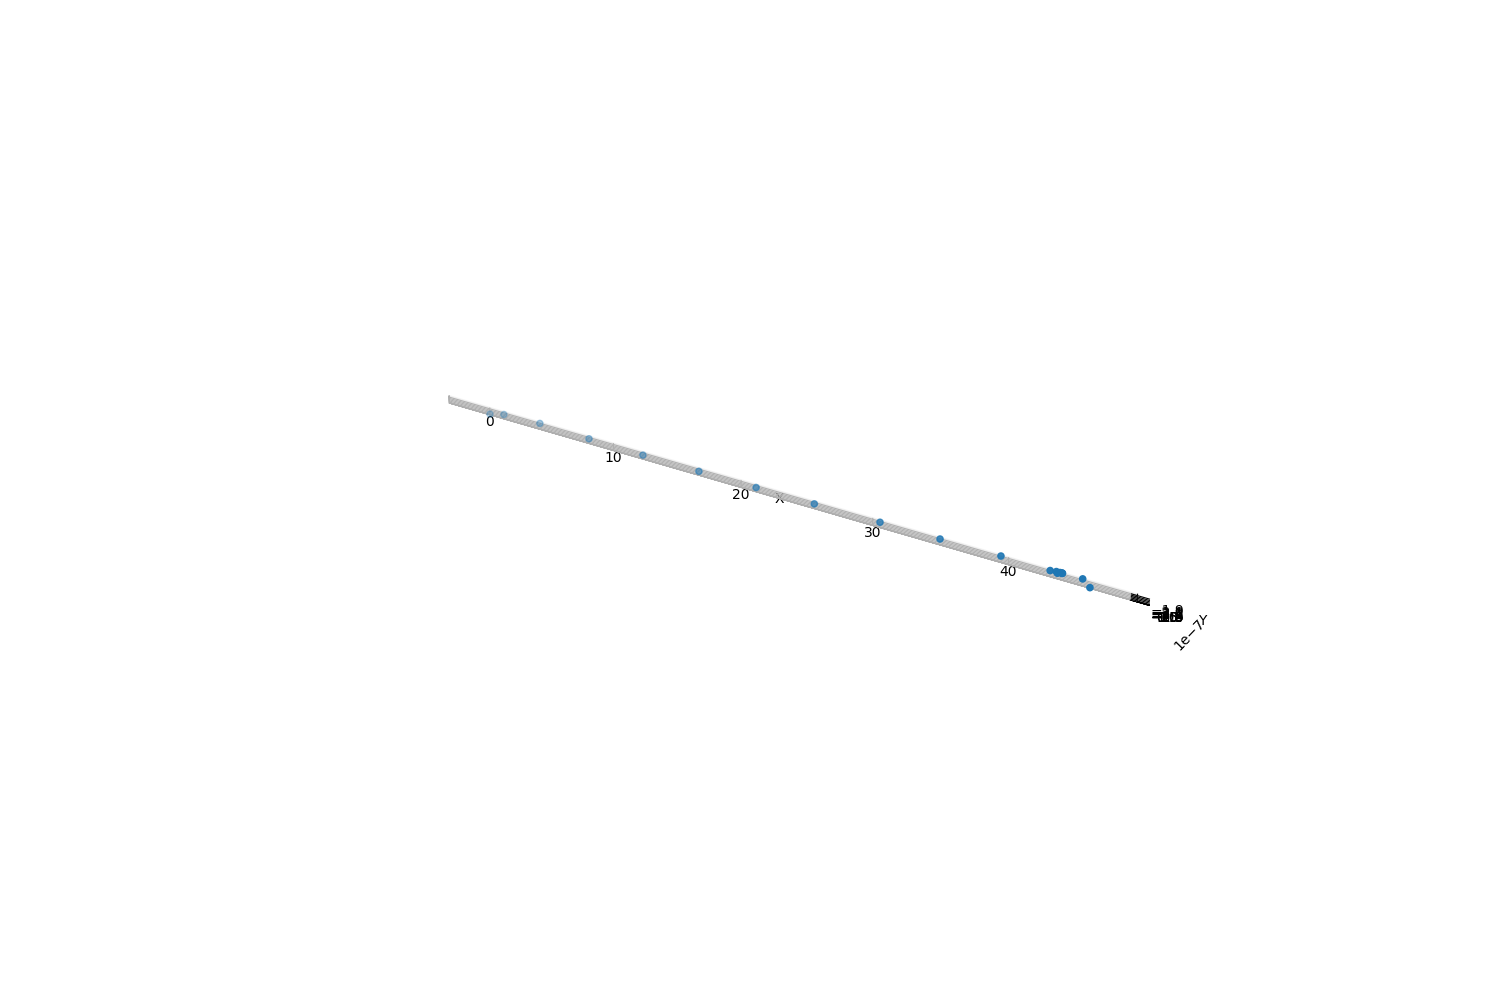

In [21]:
ax = plot_3D_setup(drone_positions)
ax.scatter(drone_positions[:,0], drone_positions[:,1], drone_positions[:,2])

In [12]:
filepath = os.path.join(os.getcwd(), '..', '..', 'data', 'results', 'l2l_abs_traj_transformations')
np.save(filepath, np.array(abs_traj_transformations))

### Torch SGD

In [22]:
from planeslam.registration import torch_register

abs_traj_transformations = np.zeros((num_scans-1,4,4))
T_abs = np.eye(4)
avg_runtime = 0

for i in range(len(scans)-1):
    start_time = time.time()
    R_hat, t_hat = torch_register(scans[i+1], scans[i], device)
    avg_runtime += time.time() - start_time
    T_hat = np.vstack((np.hstack((R_hat, t_hat)), np.hstack((np.zeros(3), 1))))
    T_abs = T_hat @ T_abs
    abs_traj_transformations[i,:,:] = T_abs

avg_runtime /= len(scans)-1
print("average registration time: ", avg_runtime)

Final loss:  0.05635499  iterations:  213
Final loss:  0.003232123  iterations:  250
Final loss:  0.0068205036  iterations:  250
Final loss:  0.013550473  iterations:  250
Final loss:  0.00122576  iterations:  34
Final loss:  0.52820355  iterations:  124
Final loss:  2.9671574  iterations:  250
Final loss:  0.00128672  iterations:  250
Final loss:  0.001626877  iterations:  250
Final loss:  0.1901042  iterations:  250
Final loss:  0.035965014  iterations:  250
Final loss:  0.0022335222  iterations:  2
Final loss:  0.0049614203  iterations:  63
Final loss:  0.112676404  iterations:  45
Final loss:  0.054204933  iterations:  129
Final loss:  0.048411854  iterations:  190
Final loss:  0.004305856  iterations:  177
Final loss:  0.0012764522  iterations:  72
Final loss:  0.040212158  iterations:  91
average registration time:  0.760691479632729


In [16]:
abs_traj_transformations[:,:3,3]

array([[  0.84602022,  -0.17770582,   0.44563508],
       [  3.87287249,  -0.19208539,  -0.67542714],
       [  7.99202936,  -0.19350368,  -1.03493508],
       [ 11.93714383,  -0.17649085,  -1.12458136],
       [ 11.93325424,  -0.17724837,  -1.1770028 ],
       [ 11.92455498,  -0.19696059,  -1.00293572],
       [ 15.93152381,  -1.7469628 ,  -0.93668146],
       [ 20.76600489,  -1.81345864,  -0.88294377],
       [ 25.12647784,  -1.75709504,  -0.90291323],
       [ 29.33359537,  -2.58309107,  -0.90490397],
       [ 33.79511793,  -2.02065139,  -1.99510189],
       [ 33.79523203,  -2.01928106,  -1.99503717],
       [ 33.78888692,  -2.20905406,  -2.00042601],
       [ 33.79025071,  -2.32184536,  -1.99719724],
       [ 32.94123437,  -2.22044126,  -4.9337797 ],
       [ 32.34060564,  -2.0979314 , -10.26207451],
       [ 32.41342903,  -2.0336166 , -11.57482255],
       [ 32.97051982,  -2.05727239, -10.03441729],
       [ 32.9839939 ,  -2.05428517,  -9.09209737]])

In [17]:
drone_positions

array([[ 0.        ,  0.        , -2.31653333],
       [ 1.15311325,  0.00000001, -2.02929187],
       [ 4.08561325,  0.00000007, -1.91195583],
       [ 8.04186153,  0.00000016, -2.00577402],
       [12.3312254 ,  0.00000006, -2.06440759],
       [16.72789192, -0.00000015, -2.06920481],
       [21.15950203, -0.00000019, -2.04602313],
       [25.60265923, -0.00000008, -2.0111804 ],
       [30.54411697, -0.00000005, -1.9673357 ],
       [34.99310684, -0.00000005, -1.92621136],
       [39.44282913, -0.        , -1.88452327],
       [43.83399582,  0.00000004, -1.84139442],
       [45.85028076,  0.00000002, -2.32305813],
       [45.31489182,  0.        , -1.83186007],
       [43.51328278,  0.00000004, -1.95378637],
       [42.99415588,  0.00000008, -1.90824699],
       [43.43586349,  0.00000005, -1.85206699],
       [43.86270905, -0.00000002, -1.85960984],
       [43.87223434, -0.00000002, -1.84669709],
       [43.69779968,  0.00000004, -1.84473574]])